<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/attention_fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

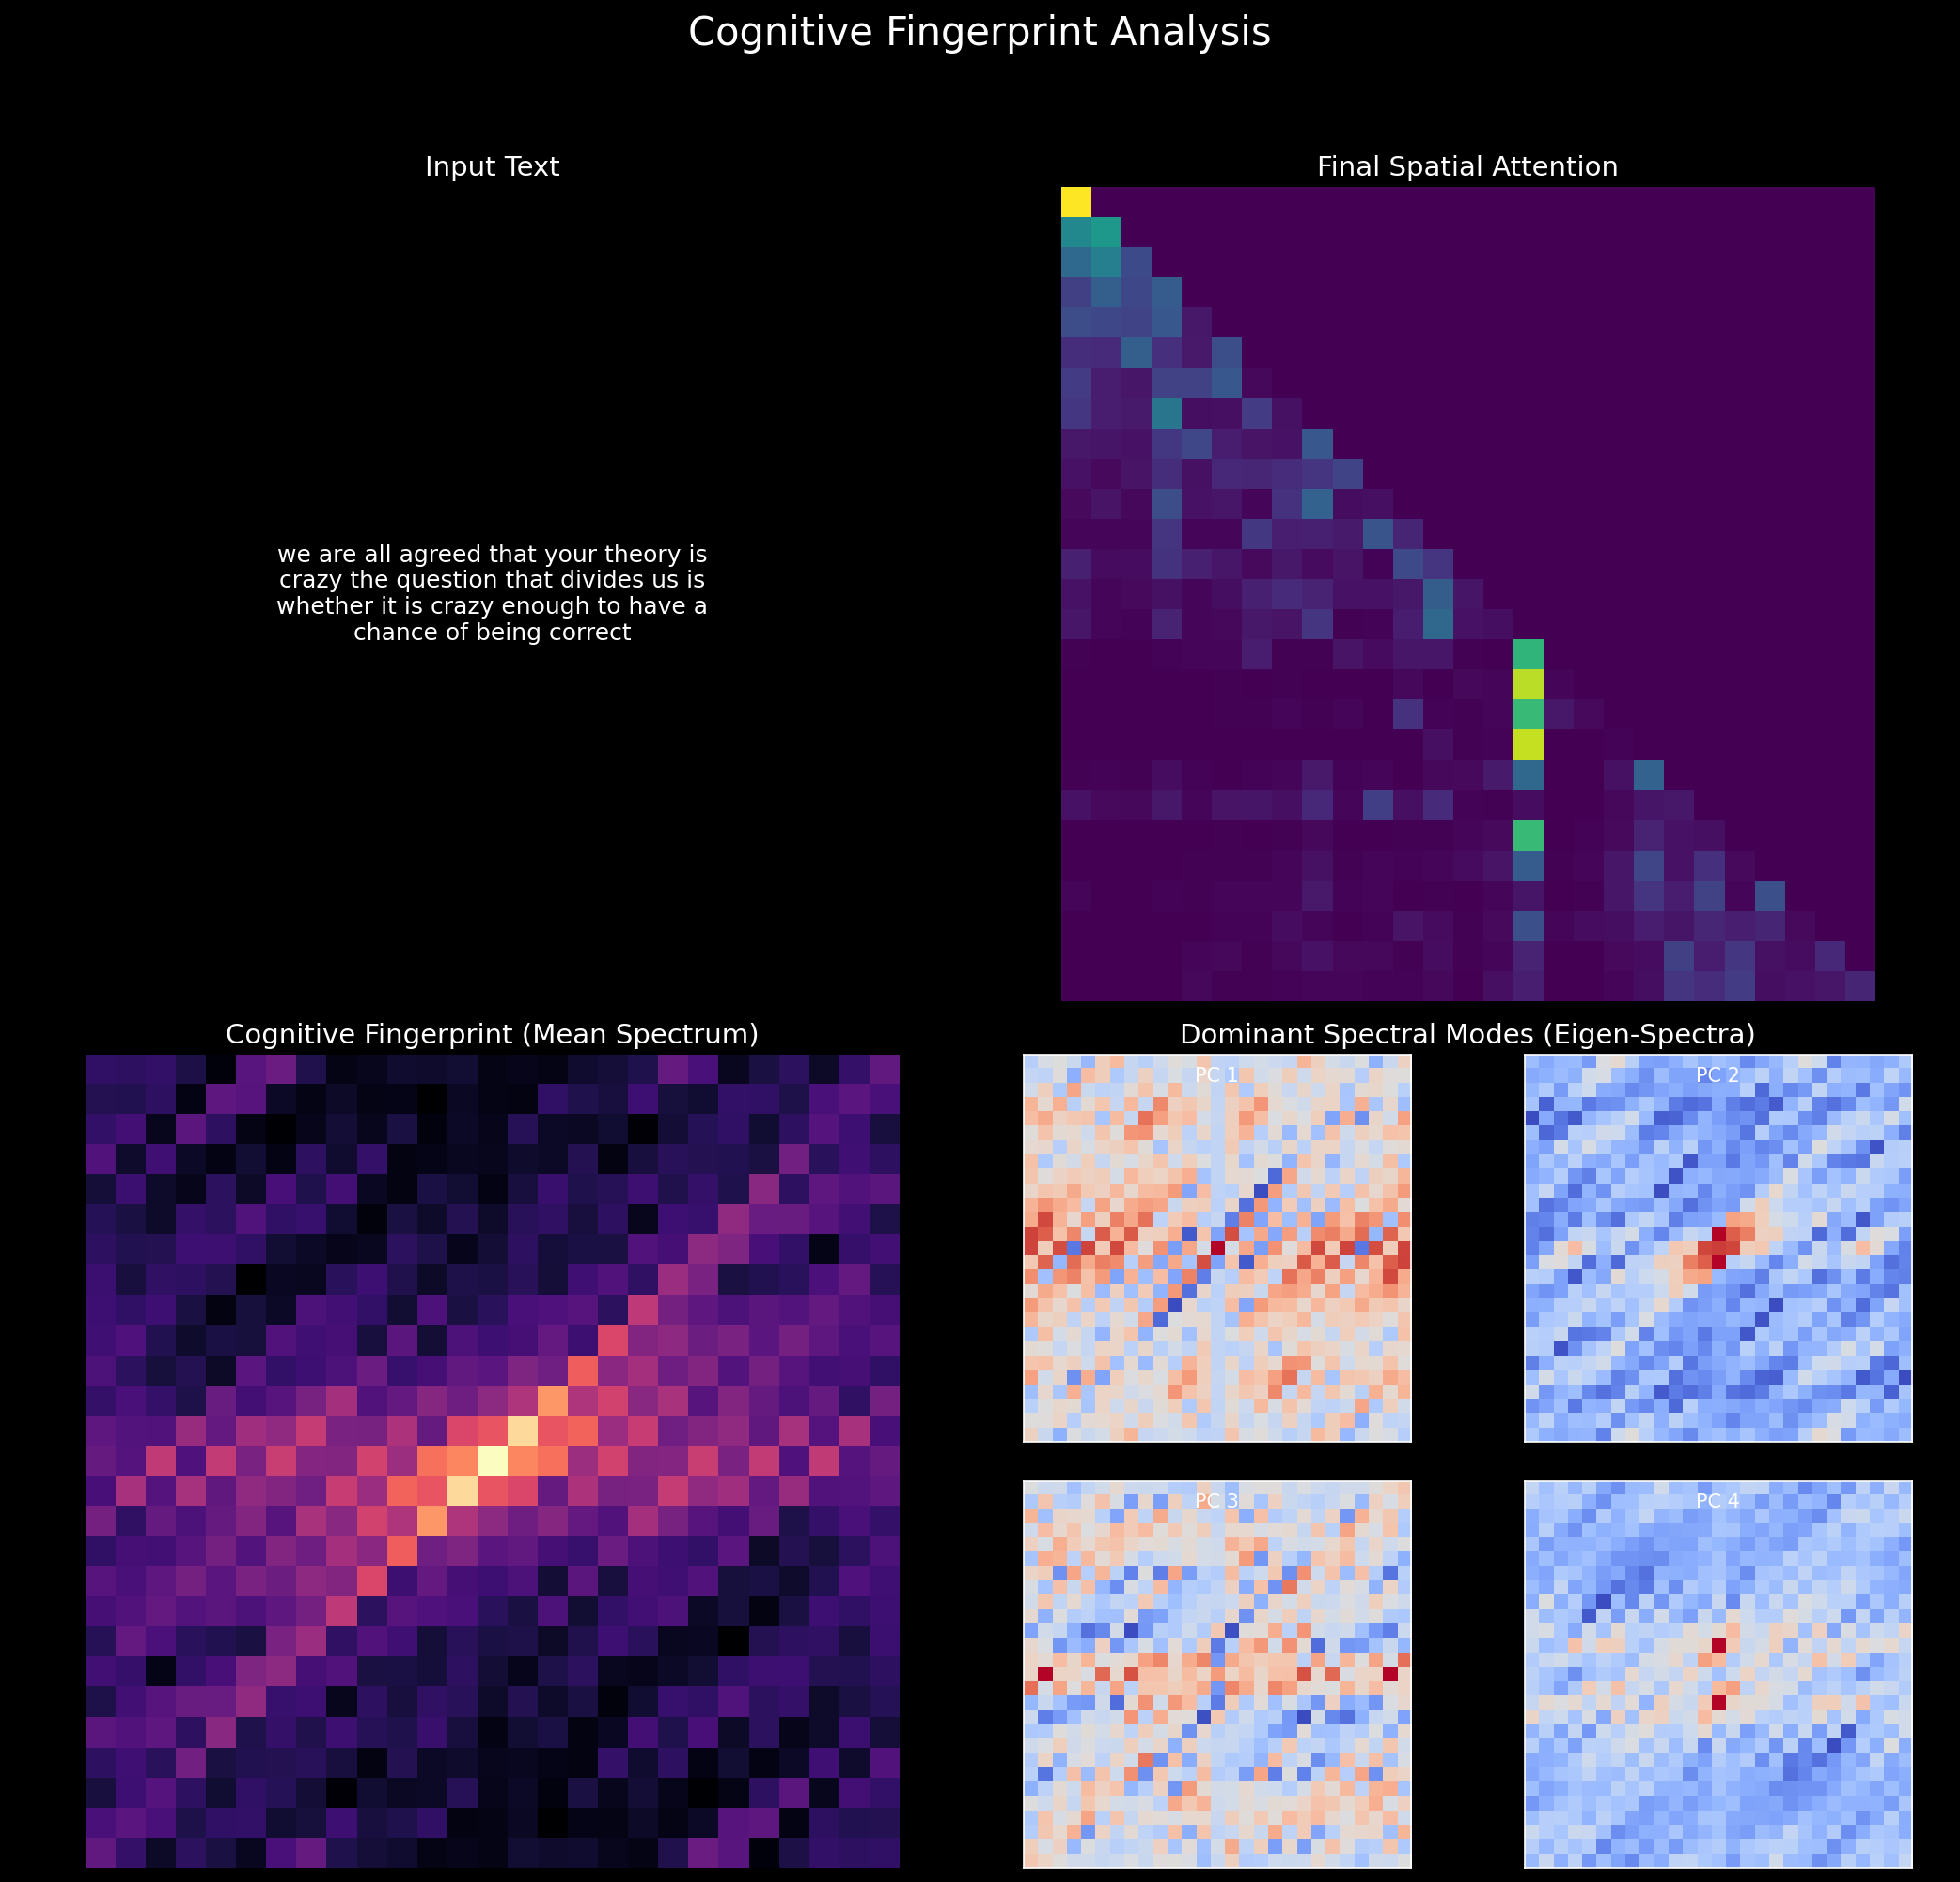

In [8]:

# 0.0 - imports
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.animation as animation
from sklearn.decomposition import PCA
import textwrap
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
plt.style.use('dark_background')

# 1.0 - configuration & constants
_1_1_model_id = "roneneldan/TinyStories-33M"

# neils bohr mode
_1_2_prompt = """we are all agreed that your theory is crazy the question that divides us is whether it is crazy enough to have a chance of being correct"""
_1_3_target_layer = 3
_1_4_target_head = 2
_1_5_n_components = 8
_1_6_sig_threshold = 1.6
_1_7_pause_duration_s = 2.5
_1_8_fps = 1
_1_9_output_file = "the_final_finale.mp4"
_1_10_device = "cpu"
_1_11_amplitude_scalar = 0.4

# 2.0 - initialization & data collection
print("... 2.0 init & collect ...")

# 2.1 - model & tokenizer
_2_1_tokenizer = AutoTokenizer.from_pretrained(_1_1_model_id)
_2_1_model = AutoModelForCausalLM.from_pretrained(_1_1_model_id).to(_1_10_device)

def _get_attention_data(prompt_text):
    inputs = _2_1_tokenizer(prompt_text, return_tensors="pt").to(_1_10_device)
    with torch.no_grad():
        outputs = _2_1_model(**inputs, output_attentions=True)
    attention = outputs.attentions[_1_3_target_layer][0, _1_4_target_head].detach().cpu()
    return {'attention': attention}

def _clean_token(token):
    return token.replace('Ġ', '').strip().upper()

# 2.2 - history structures
_2_2_history = []
_2_2_prompt_tokens = _2_1_tokenizer.tokenize(_1_2_prompt)
_2_2_final_seq_len = len(_2_2_prompt_tokens)
_2_2_master_word_list = [_clean_token(t) for t in _2_2_prompt_tokens]


# 2.3 - the collection loop
for i in range(1, len(_2_2_prompt_tokens) + 1):
    _2_3_current_prompt = _2_1_tokenizer.convert_tokens_to_string(_2_2_prompt_tokens[:i])
    if not _2_3_current_prompt: continue
    _2_3_data = _get_attention_data(_2_3_current_prompt)
    _2_4_attention_map = _2_3_data['attention']
    _2_4_padded_attention = torch.zeros(_2_2_final_seq_len, _2_2_final_seq_len)
    _2_4_current_size = _2_4_attention_map.shape[0]
    _2_4_padded_attention[:_2_4_current_size, :_2_4_current_size] = _2_4_attention_map
    _2_4_f_transform = np.fft.fftshift(np.fft.fft2(_2_4_padded_attention.numpy()))
    _2_4_spectrum = np.log(np.abs(_2_4_f_transform) + 1)
    _2_3_data['attention'] = _2_4_padded_attention
    _2_3_data['spectrum'] = _2_4_spectrum
    _2_2_history.append(_2_3_data)

# 3.0 - analysis & performance planning
print("... 3.0 analyze & plan ...")

# 3.1 - pca transformation
_3_1_all_spectra_flat = np.array([h['spectrum'].flatten() for h in _2_2_history])
_3_1_pca = PCA(n_components=_1_5_n_components)
_3_1_trajectory = _3_1_pca.fit_transform(_3_1_all_spectra_flat)

# 3.2 - significance calculation
_3_2_jumps = np.linalg.norm(np.diff(_3_1_trajectory[:, :3], axis=0), axis=1)
_3_2_significant_indices = np.where(_3_2_jumps > (_3_2_jumps.mean() + _1_6_sig_threshold * _3_2_jumps.std()))[0] + 1

# 3.3 - render plan construction
print("... 3.3 render plan construction ...")
_3_3_render_frames = []
_3_3_pause_frames = int(_1_7_pause_duration_s * _1_8_fps)
for i in range(len(_2_2_history)):
    _3_3_render_frames.append(i)
    if i in _3_2_significant_indices:
        for _ in range(_3_3_pause_frames):
            _3_3_render_frames.append(i)

_3_3_final_frame_index = len(_2_2_history) - 1
_3_3_soak_frames = int(5 * _1_8_fps)
for _ in range(_3_3_soak_frames):
    _3_3_render_frames.append(_3_3_final_frame_index)

# 4.0 - visualization & rendering
print("... 4.0 draw & render ...")

# 4.1 - staging & layout
_4_1_fig = plt.figure(figsize=(9, 16), dpi=120)
_4_1_fig.patch.set_facecolor('black')
_4_1_gs_main = GridSpec(16, 9, figure=_4_1_fig, hspace=6)
_4_1_ax_traj = _4_1_fig.add_subplot(_4_1_gs_main[0:7, :], projection='3d')
_4_1_gs_sym = GridSpecFromSubplotSpec(10, 1, subplot_spec=_4_1_gs_main[7:10, :])
_4_1_gs_dials_nested = GridSpecFromSubplotSpec(1, 2, subplot_spec=_4_1_gs_main[10:13, :], wspace=0.3)
_4_1_ax_log = _4_1_fig.add_subplot(_4_1_gs_main[13:, :])

_4_1_ax_sym = _4_1_fig.add_subplot(_4_1_gs_sym[0:8, :]); _4_1_ax_dict = _4_1_fig.add_subplot(_4_1_gs_sym[8:, :])
_4_1_ax_focal = _4_1_fig.add_subplot(_4_1_gs_dials_nested[0, 0]); _4_1_ax_shock = _4_1_fig.add_subplot(_4_1_gs_dials_nested[0, 1])

for ax in [_4_1_ax_dict, _4_1_ax_sym, _4_1_ax_focal, _4_1_ax_shock, _4_1_ax_log]: ax.axis('off')
_4_1_ax_traj.xaxis.pane.fill = _4_1_ax_traj.yaxis.pane.fill = _4_1_ax_traj.zaxis.pane.fill = False
_4_1_ax_traj.grid(color='cyan', linestyle=':', linewidth=0.5, alpha=0.3)
_4_1_ax_traj.set_title("attention trajectory", fontsize=12); _4_1_ax_sym.set_title("eigen-spectrum", fontsize=12)
_4_1_ax_focal.set_title("attention weight distro", fontsize=10); _4_1_ax_shock.set_title("state perturbation", fontsize=10)

# 4.2 - artist initialization
_4_2_ghost_path = _4_1_ax_traj.plot(_3_1_trajectory[:, 0], _3_1_trajectory[:, 1], _3_1_trajectory[:, 2], 'c--', alpha=0.3, linewidth=1.5)
_4_2_trail, = _4_1_ax_traj.plot([], [], [], 'c-', alpha=0.7, linewidth=3.0)
_4_2_head, = _4_1_ax_traj.plot([], [], [], 'o', color='yellow', markersize=10)
_4_2_word_label = _4_1_ax_traj.text(0, 0, 0, '', color='yellow', ha='center', va='center', fontweight='bold', fontsize=14, alpha=0.0)
_4_2_symphony_x = np.linspace(0, 2 * np.pi, 200)
_4_1_ax_sym.set_ylim(-1, 1)
_4_2_im_focal = _4_1_ax_focal.imshow(np.zeros((_2_2_final_seq_len, _2_2_final_seq_len)), cmap='viridis', aspect='equal')
_4_2_im_shock = _4_1_ax_shock.imshow(np.zeros((_2_2_final_seq_len, _2_2_final_seq_len)), cmap='coolwarm', aspect='equal')
_4_2_dictionary_labels = [_4_1_ax_dict.text(0,0,'', ha='center', va='center', fontsize=9, fontweight='bold') for _ in range(_1_5_n_components)]
_4_2_log_text_obj = _4_1_ax_log.text(0.5, 0.95, "", ha='center', va='top', color='white', fontsize=16, transform=_4_1_ax_log.transAxes)

# 4.3 - the update function
def _4_3_update(frame_index):
    # 4.3.1 - state check
    _actual_frame = _3_3_render_frames[frame_index]
    _is_paused = _actual_frame in _3_2_significant_indices and frame_index > 0 and _3_3_render_frames[frame_index - 1] == _actual_frame

    # 4.3.2 - trajectory update
    _pos = _3_1_trajectory[_actual_frame]
    _4_2_trail.set_data(_3_1_trajectory[:_actual_frame + 1, 0], _3_1_trajectory[:_actual_frame + 1, 1])
    _4_2_trail.set_3d_properties(_3_1_trajectory[:_actual_frame + 1, 2])
    _4_2_head.set_data([_pos[0]], [_pos[1]]); _4_2_head.set_3d_properties([_pos[2]])
    _4_2_word_label.set_position_3d((_pos[0], _pos[1], _pos[2] + 1.5))
    _4_2_word_label.set_text(_2_2_master_word_list[_actual_frame])
    _4_2_word_label.set_alpha(1.0 if not _is_paused else 0.0)

    # 4.3.3 - symphony update
    _4_1_ax_sym.clear(); _4_1_ax_sym.axis('off'); _4_1_ax_sym.set_title("eigen-spectrum", fontsize=12); _4_1_ax_sym.set_ylim(-1, 1)
    _weights = _3_1_trajectory[_actual_frame]
    _symphony_collections = []
    for i in range(_1_5_n_components):
        _wave = np.sin(_4_2_symphony_x * (i + 1)) * (_weights[i] * _1_11_amplitude_scalar)
        _collection = _4_1_ax_sym.fill_between(_4_2_symphony_x, _wave, 0, color=plt.cm.viridis(i / _1_5_n_components), alpha=0.6, linewidth=0)
        _symphony_collections.append(_collection)

    _projections = np.dot(_3_1_all_spectra_flat[:_actual_frame + 1], _3_1_pca.components_.T)
    _resonant_word_indices = np.argmax(_projections, axis=0)
    for i in range(_1_5_n_components):
        _token = _2_2_master_word_list[_resonant_word_indices[i]]
        _4_2_dictionary_labels[i].set_position(((i + 0.5) / _1_5_n_components, 0.5)); _4_2_dictionary_labels[i].set_text(f"PC{i+1}\n{_token}"); _4_2_dictionary_labels[i].set_color(plt.cm.viridis(i / _1_5_n_components))

    _spotlight_artist = None
    if _is_paused:
        _current_word = _2_2_master_word_list[_actual_frame]
        _spotlight_artist = _4_1_ax_sym.text(0.5, 0.5, _current_word, ha='center', va='center', transform=_4_1_ax_sym.transAxes, color='white', fontsize=60, fontweight='bold', alpha=1.0)

    # 4.3.4 - dials update
    _focal_data = _2_2_history[_actual_frame]['attention']
    _4_2_im_focal.set_data(_focal_data); _4_2_im_focal.set_clim(vmin=_focal_data.min(), vmax=_focal_data.max())
    if _actual_frame > 0:
        _shock_data = _2_2_history[_actual_frame]['spectrum'] - _2_2_history[_actual_frame - 1]['spectrum']
        _4_2_im_shock.set_data(_shock_data); _4_2_im_shock.set_clim(vmin=_shock_data.min(), vmax=_shock_data.max())

    # 4.3.5 - log update
    _full_text = " ".join(_2_2_master_word_list[:_actual_frame + 1])
    _wrapped_text = "\n".join(textwrap.wrap(_full_text, width=25))
    _4_2_log_text_obj.set_text(_wrapped_text)

    # 4.3.6 - the explicit return
    artists = [_4_2_trail, _4_2_head, _4_2_word_label, _4_2_im_focal, _4_2_im_shock, _4_2_log_text_obj] + _4_2_dictionary_labels + _symphony_collections
    if _spotlight_artist:
        artists.append(_spotlight_artist)
    return artists

# 4.4 - animation & saving
print("... 4.4 render ...")
_4_4_ani = animation.FuncAnimation(_4_1_fig, _4_3_update, frames=len(_3_3_render_frames), blit=True, interval=1000/_1_8_fps)
try:
    _4_4_writer = animation.FFMpegWriter(fps=_1_8_fps, metadata=dict(artist='sal pal'), bitrate=2500)
    _4_4_ani.save(_1_9_output_file, writer=_4_4_writer)
    print(f"...fin. saved to {_1_9_output_file}")
except FileNotFoundError:
    print("\n---\n!!! critical: `ffmpeg` not found. install from https://ffmpeg.org/download.html\n---")
except Exception as e:
    print(f"\n--- an unexpected error occurred during render ---\n{e}")

plt.close(_4_1_fig)

... 2.0 init & collect ...
... 3.0 analyze & plan ...
... 3.3 render plan construction ...
... 4.0 draw & render ...
... 4.4 render ...
...fin. saved to the_final_finale.mp4
